In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

sns.set_style('whitegrid')
sns.set_palette('colorblind')
%matplotlib inline

## 1. Load Results

In [17]:
# Load evaluation results
results_df = pd.read_csv('../results/evaluation_results_fast.csv')

print(f"Loaded {len(results_df)} results")
results_df.head()

Loaded 200 results


,question_id,condition,exact_match,token_f1,is_hallucination,hallucination_category,recall@k,mrr
0,5ae143ed55429920d5234360,no_rag,0.0,0.0,True,factual_error,NaN,NaN
1,5ae143ed55429920d5234360,rag_k1,0.0,0.0,True,factual_error,0.5,1.0
2,5ae143ed55429920d5234360,rag_k3,0.0,0.0,True,factual_error,0.5,1.0
3,5ae143ed55429920d5234360,rag_k5,0.0,0.0,True,factual_error,0.5,1.0
4,5abc19705542993a06baf86e,no_rag,0.0,0.0,True,factual_error,NaN,NaN


In [4]:
# Summary statistics
results_df.groupby('condition')[['exact_match', 'token_f1', 'is_hallucination']].agg(['mean', 'std'])

exact_match            token_f1           is_hallucination          
                 mean       std      mean       std             mean       std
condition                                                                     
no_rag           0.00  0.000000  0.086220  0.128302             1.00  0.000000
rag_k1           0.12  0.328261  0.190152  0.335010             0.82  0.388088
rag_k3           0.14  0.350510  0.212325  0.354672             0.76  0.431419
rag_k5           0.14  0.350510  0.214631  0.354269             0.76  0.431419

## 2. Accuracy Metrics by Condition

In [18]:
# Calculate aggregated metrics
aggregated = results_df.groupby('condition').agg({
    'exact_match': 'mean',
    'token_f1': 'mean',
    'is_hallucination': 'mean'
}).reset_index()

aggregated.columns = ['condition', 'EM', 'F1', 'Hallucination Rate']

# Order conditions
condition_order = ['no_rag', 'rag_k1', 'rag_k3', 'rag_k5']
aggregated['condition'] = pd.Categorical(aggregated['condition'], categories=condition_order, ordered=True)
aggregated = aggregated.sort_values('condition')

aggregated

,condition,EM,F1,Hallucination Rate
0,no_rag,0.00,0.086220,1.00
1,rag_k1,0.12,0.190152,0.82
2,rag_k3,0.14,0.212325,0.76
3,rag_k5,0.14,0.214631,0.76


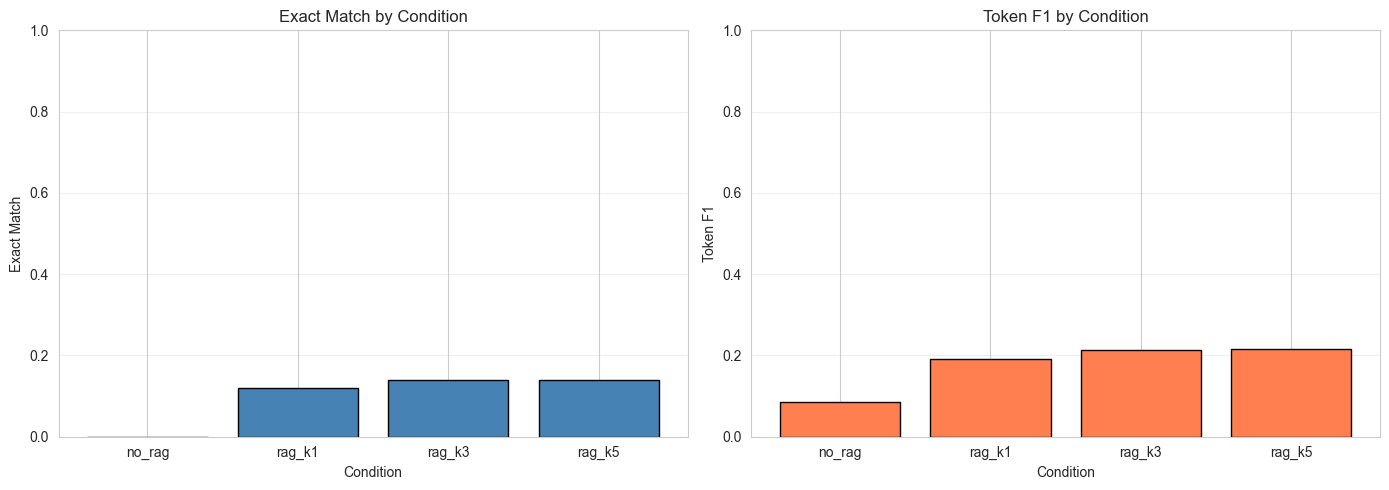

In [6]:
# Plot accuracy metrics
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Exact Match
axes[0].bar(aggregated['condition'], aggregated['EM'], color='steelblue', edgecolor='black')
axes[0].set_xlabel('Condition')
axes[0].set_ylabel('Exact Match')
axes[0].set_title('Exact Match by Condition')
axes[0].set_ylim(0, 1)
axes[0].grid(axis='y', alpha=0.3)

# Token F1
axes[1].bar(aggregated['condition'], aggregated['F1'], color='coral', edgecolor='black')
axes[1].set_xlabel('Condition')
axes[1].set_ylabel('Token F1')
axes[1].set_title('Token F1 by Condition')
axes[1].set_ylim(0, 1)
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('../results/accuracy_by_condition.png', dpi=300, bbox_inches='tight')
plt.show()

## 3. Hallucination Analysis

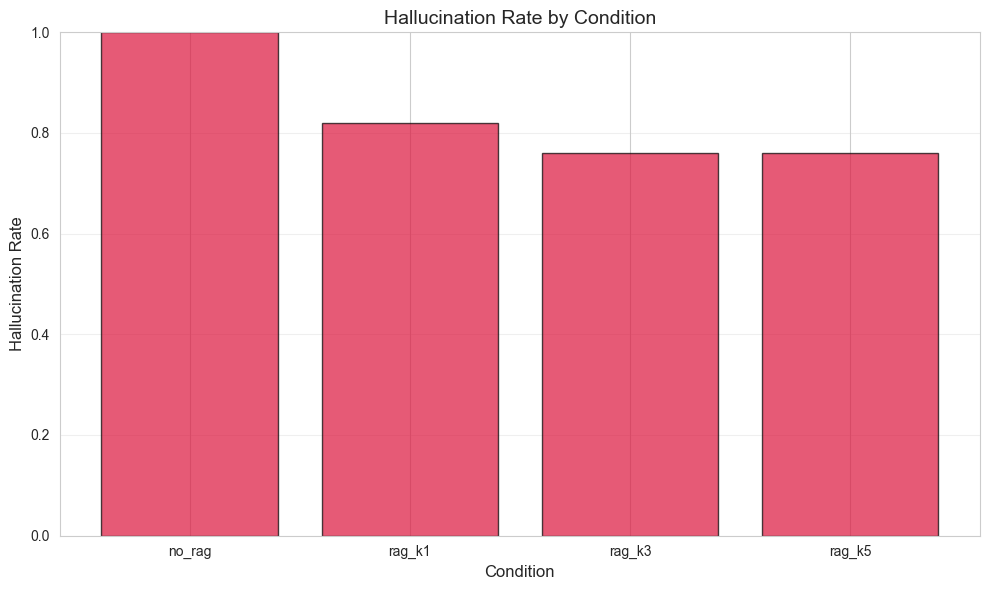

In [7]:
# Hallucination rate by condition
plt.figure(figsize=(10, 6))
plt.bar(aggregated['condition'], aggregated['Hallucination Rate'], 
        color='crimson', edgecolor='black', alpha=0.7)
plt.xlabel('Condition', fontsize=12)
plt.ylabel('Hallucination Rate', fontsize=12)
plt.title('Hallucination Rate by Condition', fontsize=14)
plt.ylim(0, 1)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('../results/hallucination_by_condition.png', dpi=300, bbox_inches='tight')
plt.show()

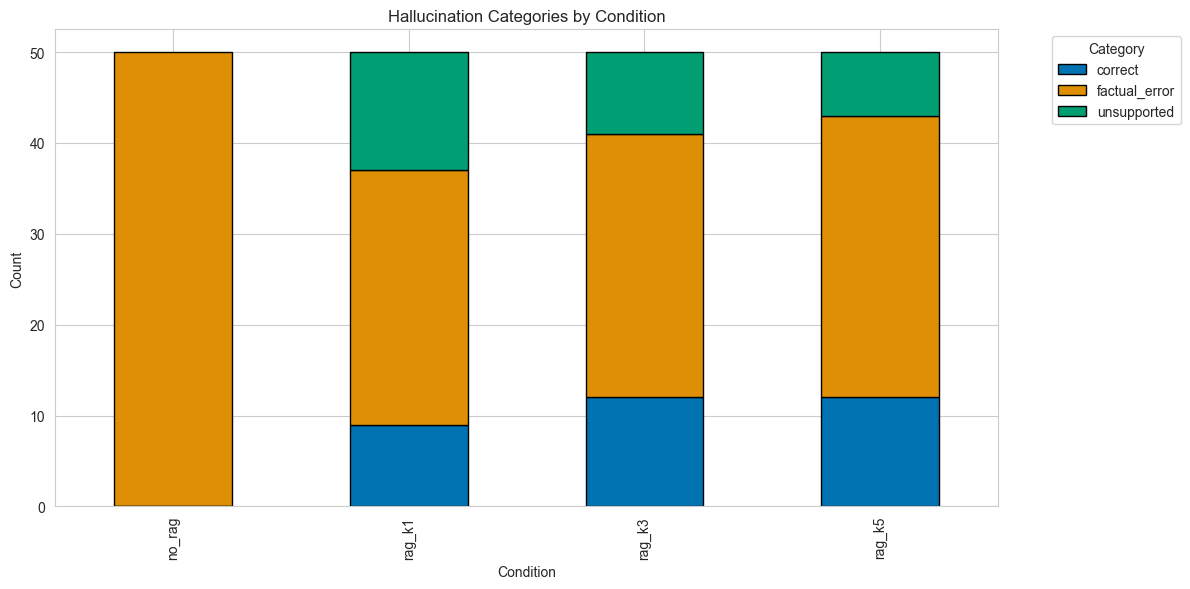

In [8]:
# Hallucination categories
if 'hallucination_category' in results_df.columns:
    category_counts = results_df.groupby(['condition', 'hallucination_category']).size().unstack(fill_value=0)
    
    category_counts.plot(kind='bar', stacked=True, figsize=(12, 6), edgecolor='black')
    plt.xlabel('Condition')
    plt.ylabel('Count')
    plt.title('Hallucination Categories by Condition')
    plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig('../results/hallucination_categories.png', dpi=300, bbox_inches='tight')
    plt.show()

## 4. Accuracy vs K (Retrieval Depth)

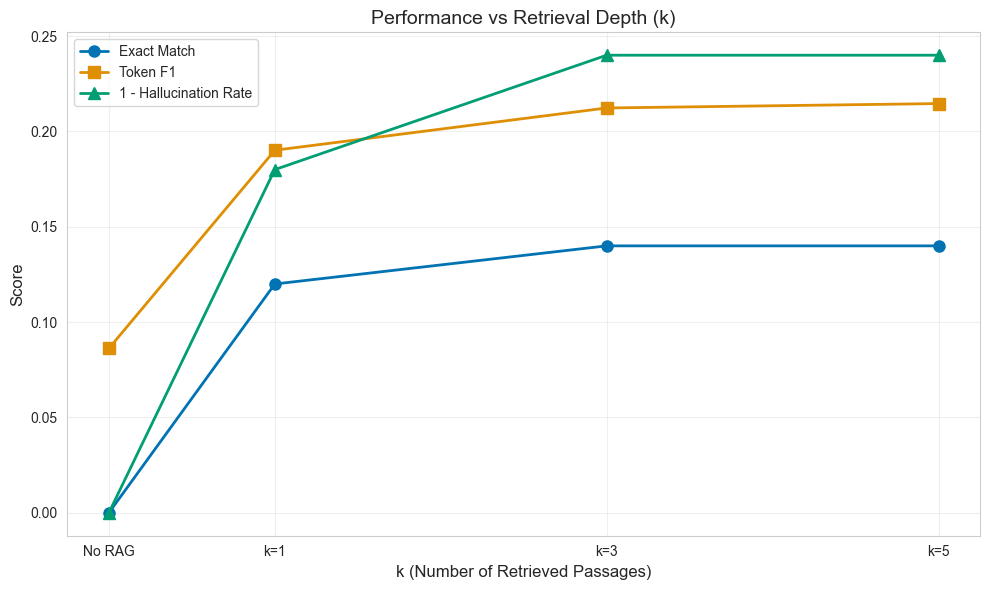

In [19]:
# Extract k values from RAG conditions
rag_results = aggregated[aggregated['condition'].str.startswith('rag')].copy()
rag_results['k'] = rag_results['condition'].str.extract(r'k(\d+)').astype(int)

# Add no-RAG as k=0
no_rag = aggregated[aggregated['condition'] == 'no_rag'].copy()
no_rag['k'] = 0

combined = pd.concat([no_rag, rag_results]).sort_values('k')

# Plot
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(combined['k'], combined['EM'], marker='o', linewidth=2, markersize=8, label='Exact Match')
ax.plot(combined['k'], combined['F1'], marker='s', linewidth=2, markersize=8, label='Token F1')
ax.plot(combined['k'], 1 - combined['Hallucination Rate'], marker='^', linewidth=2, 
        markersize=8, label='1 - Hallucination Rate')

ax.set_xlabel('k (Number of Retrieved Passages)', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Performance vs Retrieval Depth (k)', fontsize=14)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_xticks(combined['k'])
ax.set_xticklabels(['No RAG' if x == 0 else f'k={x}' for x in combined['k']])

plt.tight_layout()
plt.savefig('../results/performance_vs_k.png', dpi=300, bbox_inches='tight')
plt.show()

## 5. Retrieval Quality Analysis

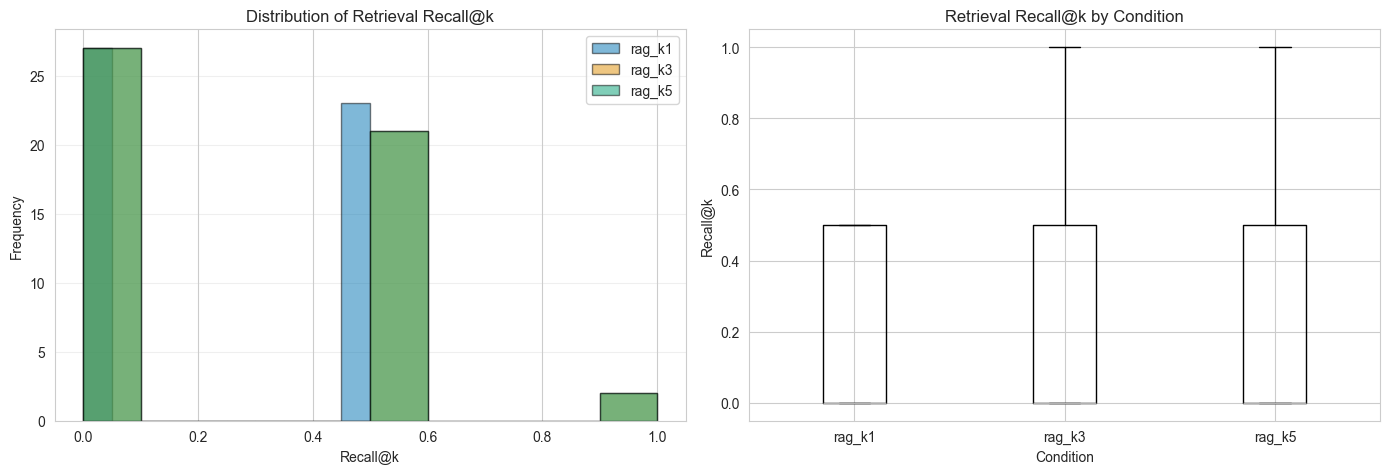

In [20]:
# Filter RAG conditions with retrieval metrics
rag_df = results_df[results_df['condition'].str.startswith('rag')].copy()

if 'recall@k' in rag_df.columns:
    # Recall@k distribution
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Histogram
    for condition in ['rag_k1', 'rag_k3', 'rag_k5']:
        data = rag_df[rag_df['condition'] == condition]['recall@k']
        axes[0].hist(data, alpha=0.5, label=condition, bins=10, edgecolor='black')
    
    axes[0].set_xlabel('Recall@k')
    axes[0].set_ylabel('Frequency')
    axes[0].set_title('Distribution of Retrieval Recall@k')
    axes[0].legend()
    axes[0].grid(axis='y', alpha=0.3)
    
    # Box plot
    rag_df.boxplot(column='recall@k', by='condition', ax=axes[1])
    axes[1].set_xlabel('Condition')
    axes[1].set_ylabel('Recall@k')
    axes[1].set_title('Retrieval Recall@k by Condition')
    axes[1].get_figure().suptitle('')  # Remove default title
    
    plt.tight_layout()
    plt.savefig('../results/retrieval_quality.png', dpi=300, bbox_inches='tight')
    plt.show()

## 6. Correlation: Retrieval Quality vs Correctness

Spearman correlation (Recall@k vs EM): ρ = 0.208, p = 0.0106
Spearman correlation (Recall@k vs F1): ρ = 0.191, p = 0.0190


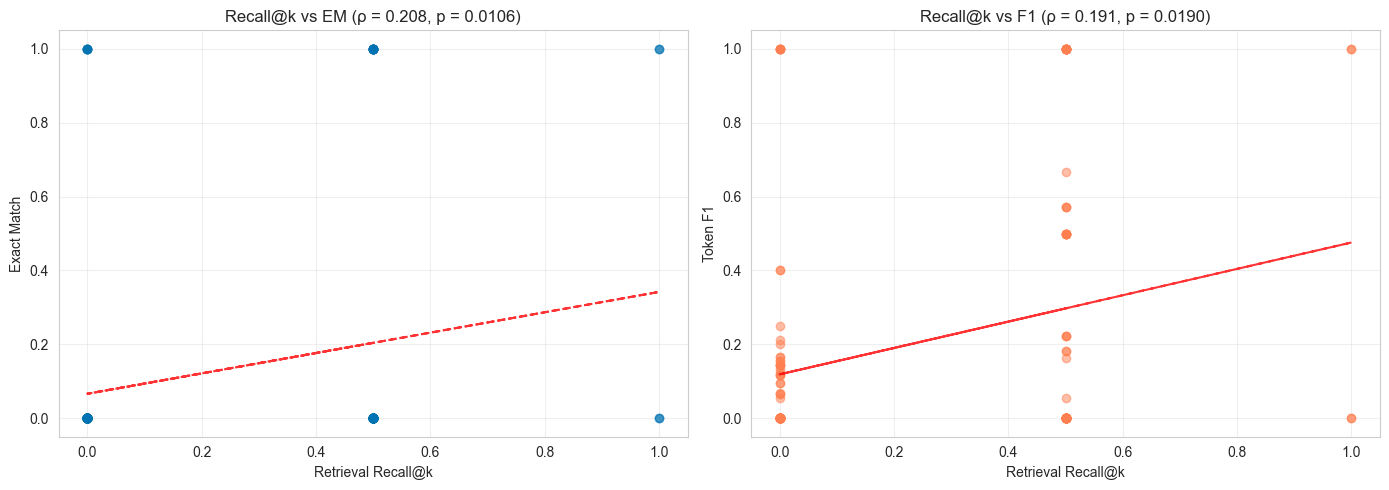

In [21]:
# Correlation analysis for RAG conditions
if 'recall@k' in rag_df.columns:
    # Spearman correlation
    corr_em, p_em = stats.spearmanr(rag_df['recall@k'], rag_df['exact_match'])
    corr_f1, p_f1 = stats.spearmanr(rag_df['recall@k'], rag_df['token_f1'])
    
    print(f"Spearman correlation (Recall@k vs EM): ρ = {corr_em:.3f}, p = {p_em:.4f}")
    print(f"Spearman correlation (Recall@k vs F1): ρ = {corr_f1:.3f}, p = {p_f1:.4f}")
    
    # Scatter plot
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # EM vs Recall
    axes[0].scatter(rag_df['recall@k'], rag_df['exact_match'], alpha=0.5)
    axes[0].set_xlabel('Retrieval Recall@k')
    axes[0].set_ylabel('Exact Match')
    axes[0].set_title(f'Recall@k vs EM (ρ = {corr_em:.3f}, p = {p_em:.4f})')
    axes[0].grid(True, alpha=0.3)
    
    # Add trend line
    z = np.polyfit(rag_df['recall@k'], rag_df['exact_match'], 1)
    p = np.poly1d(z)
    axes[0].plot(rag_df['recall@k'], p(rag_df['recall@k']), "r--", alpha=0.8)
    
    # F1 vs Recall
    axes[1].scatter(rag_df['recall@k'], rag_df['token_f1'], alpha=0.5, color='coral')
    axes[1].set_xlabel('Retrieval Recall@k')
    axes[1].set_ylabel('Token F1')
    axes[1].set_title(f'Recall@k vs F1 (ρ = {corr_f1:.3f}, p = {p_f1:.4f})')
    axes[1].grid(True, alpha=0.3)
    
    # Add trend line
    z = np.polyfit(rag_df['recall@k'], rag_df['token_f1'], 1)
    p = np.poly1d(z)
    axes[1].plot(rag_df['recall@k'], p(rag_df['recall@k']), "r--", alpha=0.8)
    
    plt.tight_layout()
    plt.savefig('../results/correlation_retrieval_correctness.png', dpi=300, bbox_inches='tight')
    plt.show()

## 7. Statistical Comparison Summary

In [12]:
pip install statsmodels

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [22]:
# Compare No-RAG vs each RAG condition
# Fallback mcnemar if statsmodels not installed
from statsmodels.stats.contingency_tables import mcnemar

no_rag_df = results_df[results_df['condition'] == 'no_rag'].sort_values('question_id')

comparisons = []

for rag_condition in ['rag_k1', 'rag_k3', 'rag_k5']:
    rag_df_cond = results_df[results_df['condition'] == rag_condition].sort_values('question_id')
    
    # Ensure same questions
    if len(no_rag_df) != len(rag_df_cond):
        print(f"Warning: Different number of examples for {rag_condition}")
        continue
    
    # Create contingency table
    both_correct = ((no_rag_df['exact_match'].values == 1) & (rag_df_cond['exact_match'].values == 1)).sum()
    no_rag_only = ((no_rag_df['exact_match'].values == 1) & (rag_df_cond['exact_match'].values == 0)).sum()
    rag_only = ((no_rag_df['exact_match'].values == 0) & (rag_df_cond['exact_match'].values == 1)).sum()
    both_wrong = ((no_rag_df['exact_match'].values == 0) & (rag_df_cond['exact_match'].values == 0)).sum()
    
    # McNemar test
    table = [[both_correct, no_rag_only], [rag_only, both_wrong]]
    result = mcnemar(table, exact=False, correction=True)
    
    # Metrics
    em_diff = rag_df_cond['exact_match'].mean() - no_rag_df['exact_match'].mean()
    f1_diff = rag_df_cond['token_f1'].mean() - no_rag_df['token_f1'].mean()
    hall_diff = no_rag_df['is_hallucination'].mean() - rag_df_cond['is_hallucination'].mean()
    
    comparisons.append({
        'Comparison': f'no_rag vs {rag_condition}',
        'ΔEM': em_diff,
        'ΔF1': f1_diff,
        'ΔHall': hall_diff,
        'p-value': result.pvalue,
        'Significant': result.pvalue < 0.05
    })

comparison_df = pd.DataFrame(comparisons)
comparison_df

,Comparison,ΔEM,ΔF1,ΔHall,p-value,Significant
0,no_rag vs rag_k1,0.12,0.103931,0.18,0.041227,True
1,no_rag vs rag_k3,0.14,0.126104,0.24,0.023342,True
2,no_rag vs rag_k5,0.14,0.128410,0.24,0.023342,True


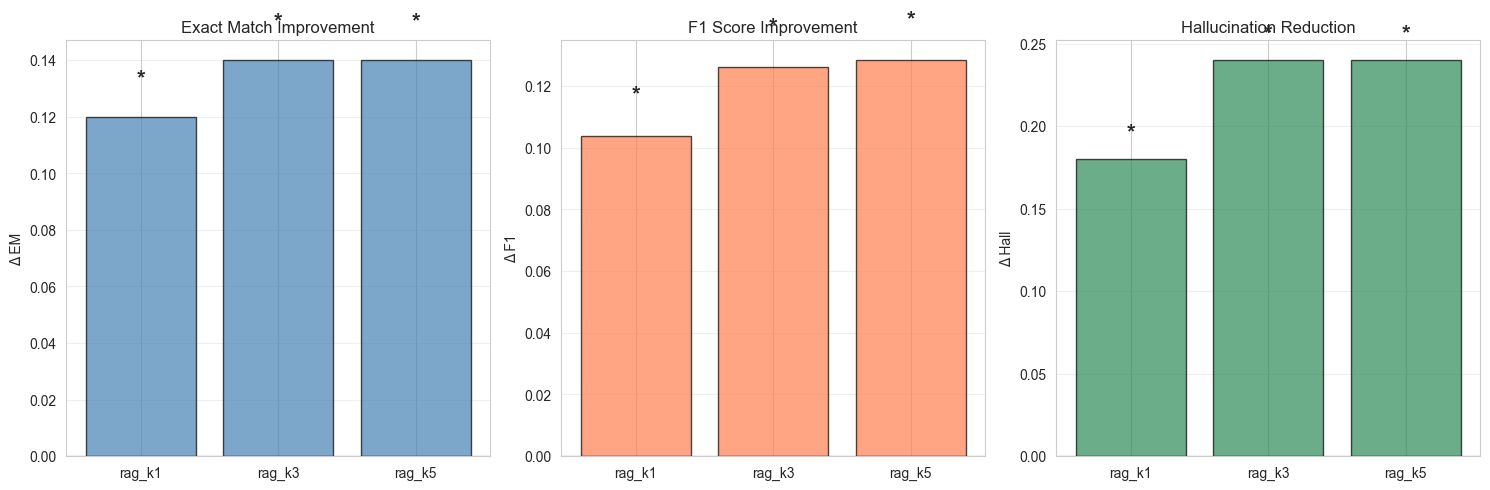

* indicates statistically significant difference (p < 0.05)


In [14]:
# Visualize improvements
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

metrics = ['ΔEM', 'ΔF1', 'ΔHall']
titles = ['Exact Match Improvement', 'F1 Score Improvement', 'Hallucination Reduction']
colors = ['steelblue', 'coral', 'seagreen']

for i, (metric, title, color) in enumerate(zip(metrics, titles, colors)):
    bars = axes[i].bar(range(len(comparison_df)), comparison_df[metric], 
                       color=color, edgecolor='black', alpha=0.7)
    axes[i].axhline(y=0, color='black', linestyle='-', linewidth=0.8)
    axes[i].set_xticks(range(len(comparison_df)))
    axes[i].set_xticklabels([c.split('vs ')[1] for c in comparison_df['Comparison']], rotation=0)
    axes[i].set_ylabel(f'Δ {metric[1:]}')
    axes[i].set_title(title)
    axes[i].grid(axis='y', alpha=0.3)
    
    # Mark significant results
    for j, (val, sig) in enumerate(zip(comparison_df[metric], comparison_df['Significant'])):
        if sig:
            axes[i].text(j, val + 0.01 if val > 0 else val - 0.01, '*', 
                        ha='center', va='bottom' if val > 0 else 'top', fontsize=16, fontweight='bold')

plt.tight_layout()
plt.savefig('../results/statistical_comparisons.png', dpi=300, bbox_inches='tight')
plt.show()

print("* indicates statistically significant difference (p < 0.05)")

## 8. Error Analysis

In [15]:
# Find interesting cases
no_rag_df = results_df[results_df['condition'] == 'no_rag'].set_index('question_id')
rag_k3_df = results_df[results_df['condition'] == 'rag_k3'].set_index('question_id')

# RAG helped cases (wrong without RAG, correct with RAG)
rag_helped = no_rag_df[(no_rag_df['exact_match'] == 0) & 
                        (rag_k3_df['exact_match'] == 1)].index.tolist()

# RAG hurt cases (correct without RAG, wrong with RAG)
rag_hurt = no_rag_df[(no_rag_df['exact_match'] == 1) & 
                      (rag_k3_df['exact_match'] == 0)].index.tolist()

# Both failed
both_failed = no_rag_df[(no_rag_df['exact_match'] == 0) & 
                         (rag_k3_df['exact_match'] == 0)].index.tolist()

print(f"RAG helped: {len(rag_helped)} cases")
print(f"RAG hurt: {len(rag_hurt)} cases")
print(f"Both failed: {len(both_failed)} cases")

# Save for manual review
error_analysis = {
    'rag_helped': rag_helped[:5],
    'rag_hurt': rag_hurt[:5],
    'both_failed': both_failed[:5]
}

import json
with open('../results/error_analysis_sample.json', 'w') as f:
    json.dump(error_analysis, f, indent=2)

print("\nSample question IDs saved for error analysis")

RAG helped: 7 cases
RAG hurt: 0 cases
Both failed: 43 cases

Sample question IDs saved for error analysis


## Summary

This notebook provides comprehensive visualization and analysis of RAG experiment results:

1. **Accuracy metrics** by condition
2. **Hallucination analysis** and categories
3. **Performance vs k** (retrieval depth)
4. **Retrieval quality** distributions
5. **Correlation** between retrieval quality and correctness
6. **Statistical comparisons** with McNemar's test
7. **Error analysis** cases for manual review

All plots are saved to `results/` directory.

## 9. Presentation-Ready Plots (Minimal Black & White)

Create minimal, publication-quality plots in black and white with selective color use only where it adds clarity.

In [23]:
# Set minimal style for presentation plots
plt.style.use('default')
sns.set_style('white')

# Create presentation plots directory
import os
os.makedirs('../presentation_plots', exist_ok=True)

print("Creating minimal presentation-ready plots...")

Creating minimal presentation-ready plots...


/var/folders/7_/ssv03k7j6nsbsjnddzst3bwc0000gn/T/ipykernel_50364/3206789259.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['No RAG', 'RAG k=1', 'RAG k=3', 'RAG k=5'], fontsize=11)


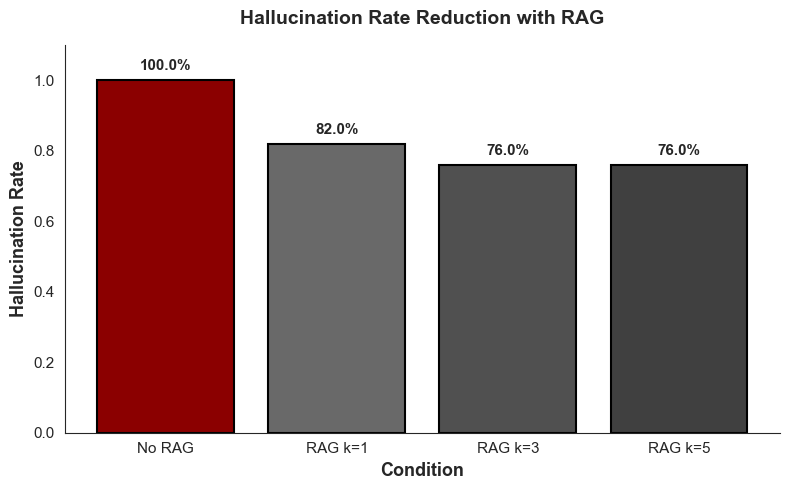

✓ Plot 1: Hallucination Rate (red accent for emphasis)


In [24]:
# PLOT 1: Hallucination Rate by Condition (Red gradient for emphasis)
fig, ax = plt.subplots(figsize=(8, 5))

# Use grayscale with red accent for hallucination (where color adds clarity)
colors = ['#8B0000', '#696969', '#505050', '#404040']  # Dark red for no-RAG, grays for RAG

bars = ax.bar(aggregated['condition'], aggregated['Hallucination Rate'], 
              color=colors, edgecolor='black', linewidth=1.5)

ax.set_xlabel('Condition', fontsize=13, fontweight='bold')
ax.set_ylabel('Hallucination Rate', fontsize=13, fontweight='bold')
ax.set_title('Hallucination Rate Reduction with RAG', fontsize=14, fontweight='bold', pad=15)
ax.set_ylim(0, 1.1)
ax.set_xticklabels(['No RAG', 'RAG k=1', 'RAG k=3', 'RAG k=5'], fontsize=11)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=11)

# Add value labels on bars
for i, (bar, val) in enumerate(zip(bars, aggregated['Hallucination Rate'])):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.02,
            f'{val:.1%}', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('../presentation_plots/1_hallucination_rate.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.savefig('../presentation_plots/1_hallucination_rate.pdf', bbox_inches='tight', facecolor='white')
plt.show()
print("✓ Plot 1: Hallucination Rate (red accent for emphasis)")

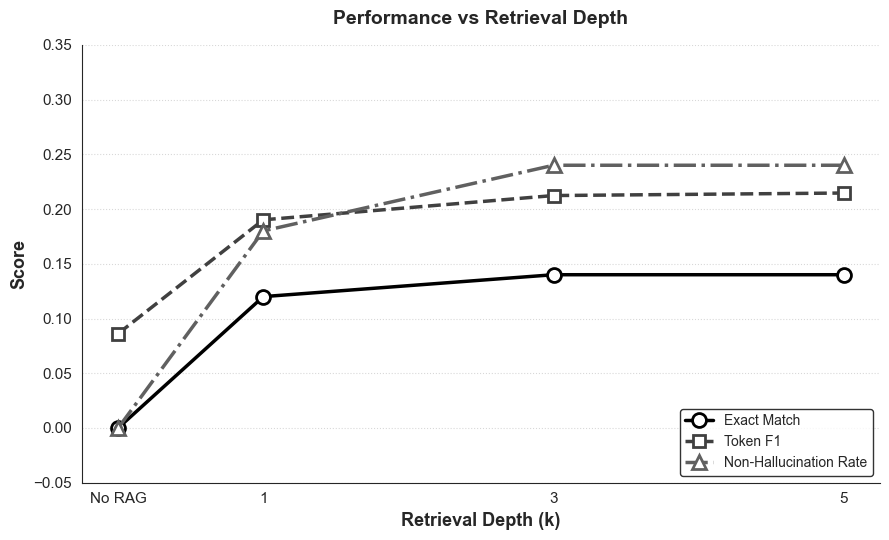

✓ Plot 2: Performance vs K (B&W with distinct markers)


In [25]:
# PLOT 2: Performance vs K (Black and white with distinct markers)
fig, ax = plt.subplots(figsize=(9, 5.5))

# Use distinct line styles and markers (no color)
ax.plot(combined['k'], combined['EM'], 
        marker='o', linewidth=2.5, markersize=10, color='black', 
        linestyle='-', label='Exact Match', markerfacecolor='white', markeredgewidth=2)

ax.plot(combined['k'], combined['F1'], 
        marker='s', linewidth=2.5, markersize=9, color='#404040', 
        linestyle='--', label='Token F1', markerfacecolor='white', markeredgewidth=2)

ax.plot(combined['k'], 1 - combined['Hallucination Rate'], 
        marker='^', linewidth=2.5, markersize=10, color='#606060', 
        linestyle='-.', label='Non-Hallucination Rate', markerfacecolor='white', markeredgewidth=2)

ax.set_xlabel('Retrieval Depth (k)', fontsize=13, fontweight='bold')
ax.set_ylabel('Score', fontsize=13, fontweight='bold')
ax.set_title('Performance vs Retrieval Depth', fontsize=14, fontweight='bold', pad=15)
ax.legend(fontsize=10, frameon=True, edgecolor='black', loc='lower right')
ax.set_xticks(combined['k'])
ax.set_xticklabels(['No RAG' if x == 0 else f'{x}' for x in combined['k']], fontsize=11)
ax.set_ylim(-0.05, 0.35)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=11)
ax.grid(axis='y', alpha=0.3, linestyle=':', color='gray')

plt.tight_layout()
plt.savefig('../presentation_plots/2_performance_vs_k.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.savefig('../presentation_plots/2_performance_vs_k.pdf', bbox_inches='tight', facecolor='white')
plt.show()
print("✓ Plot 2: Performance vs K (B&W with distinct markers)")

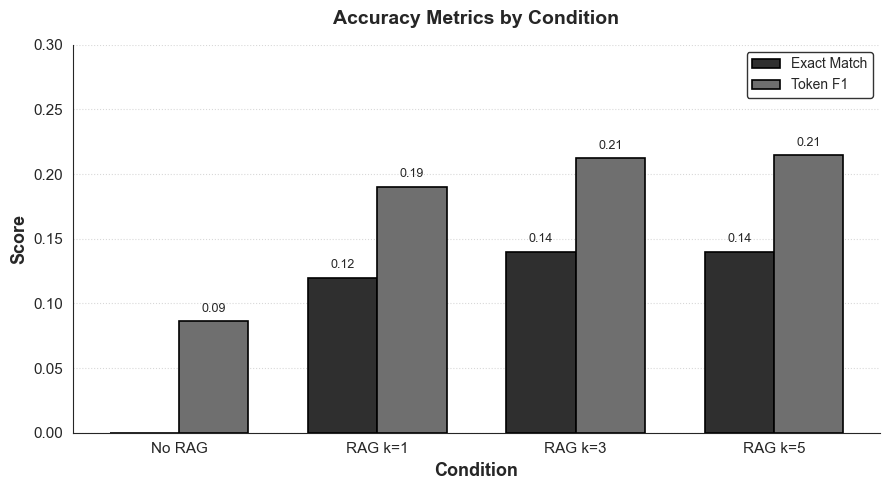

✓ Plot 3: Accuracy Metrics (grayscale)


In [26]:
# PLOT 3: Accuracy Metrics by Condition (Grayscale bars)
fig, ax = plt.subplots(figsize=(9, 5))

x = np.arange(len(aggregated))
width = 0.35

# Use grayscale only
bars1 = ax.bar(x - width/2, aggregated['EM'], width, 
               label='Exact Match', color='#2F2F2F', edgecolor='black', linewidth=1.2)
bars2 = ax.bar(x + width/2, aggregated['F1'], width, 
               label='Token F1', color='#6F6F6F', edgecolor='black', linewidth=1.2)

ax.set_xlabel('Condition', fontsize=13, fontweight='bold')
ax.set_ylabel('Score', fontsize=13, fontweight='bold')
ax.set_title('Accuracy Metrics by Condition', fontsize=14, fontweight='bold', pad=15)
ax.set_xticks(x)
ax.set_xticklabels(['No RAG', 'RAG k=1', 'RAG k=3', 'RAG k=5'], fontsize=11)
ax.legend(fontsize=10, frameon=True, edgecolor='black')
ax.set_ylim(0, 0.3)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=11)
ax.grid(axis='y', alpha=0.3, linestyle=':', color='gray')

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        if height > 0.01:
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.005,
                   f'{height:.2f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('../presentation_plots/3_accuracy_metrics.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.savefig('../presentation_plots/3_accuracy_metrics.pdf', bbox_inches='tight', facecolor='white')
plt.show()
print("✓ Plot 3: Accuracy Metrics (grayscale)")

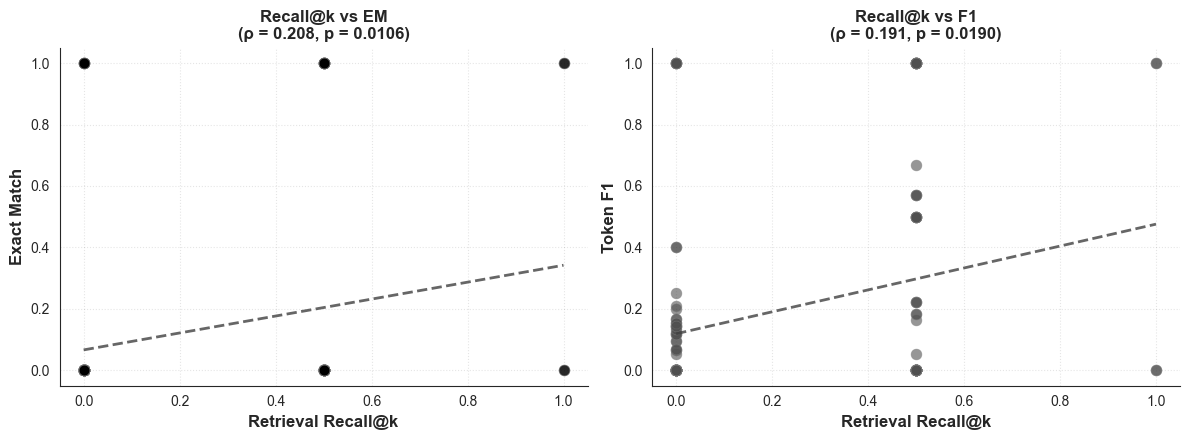

✓ Plot 4: Correlation (grayscale scatter)


In [27]:
# PLOT 4: Correlation (Retrieval Quality vs Correctness) - Grayscale scatter
if 'recall@k' in rag_df.columns:
    # Spearman correlation
    corr_em, p_em = stats.spearmanr(rag_df['recall@k'], rag_df['exact_match'])
    corr_f1, p_f1 = stats.spearmanr(rag_df['recall@k'], rag_df['token_f1'])
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 4.5))
    
    # EM vs Recall - black scatter with trend line
    axes[0].scatter(rag_df['recall@k'], rag_df['exact_match'], 
                   alpha=0.6, s=60, color='black', edgecolors='gray', linewidth=0.5)
    axes[0].set_xlabel('Retrieval Recall@k', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('Exact Match', fontsize=12, fontweight='bold')
    axes[0].set_title(f'Recall@k vs EM\n(ρ = {corr_em:.3f}, p = {p_em:.4f})', 
                     fontsize=12, fontweight='bold')
    axes[0].spines['top'].set_visible(False)
    axes[0].spines['right'].set_visible(False)
    axes[0].tick_params(axis='both', which='major', labelsize=10)
    axes[0].grid(True, alpha=0.2, linestyle=':', color='gray')
    
    # Add trend line
    z = np.polyfit(rag_df['recall@k'], rag_df['exact_match'], 1)
    p_line = np.poly1d(z)
    x_trend = np.linspace(rag_df['recall@k'].min(), rag_df['recall@k'].max(), 100)
    axes[0].plot(x_trend, p_line(x_trend), "--", color='#404040', linewidth=2, alpha=0.8)
    
    # F1 vs Recall - gray scatter with trend line
    axes[1].scatter(rag_df['recall@k'], rag_df['token_f1'], 
                   alpha=0.6, s=60, color='#505050', edgecolors='gray', linewidth=0.5)
    axes[1].set_xlabel('Retrieval Recall@k', fontsize=12, fontweight='bold')
    axes[1].set_ylabel('Token F1', fontsize=12, fontweight='bold')
    axes[1].set_title(f'Recall@k vs F1\n(ρ = {corr_f1:.3f}, p = {p_f1:.4f})', 
                     fontsize=12, fontweight='bold')
    axes[1].spines['top'].set_visible(False)
    axes[1].spines['right'].set_visible(False)
    axes[1].tick_params(axis='both', which='major', labelsize=10)
    axes[1].grid(True, alpha=0.2, linestyle=':', color='gray')
    
    # Add trend line
    z = np.polyfit(rag_df['recall@k'], rag_df['token_f1'], 1)
    p_line = np.poly1d(z)
    axes[1].plot(x_trend, p_line(x_trend), "--", color='#404040', linewidth=2, alpha=0.8)
    
    plt.tight_layout()
    plt.savefig('../presentation_plots/4_correlation.png', dpi=300, bbox_inches='tight', facecolor='white')
    plt.savefig('../presentation_plots/4_correlation.pdf', bbox_inches='tight', facecolor='white')
    plt.show()
    print("✓ Plot 4: Correlation (grayscale scatter)")
else:
    print("⚠ Recall@k data not available, skipping correlation plot")

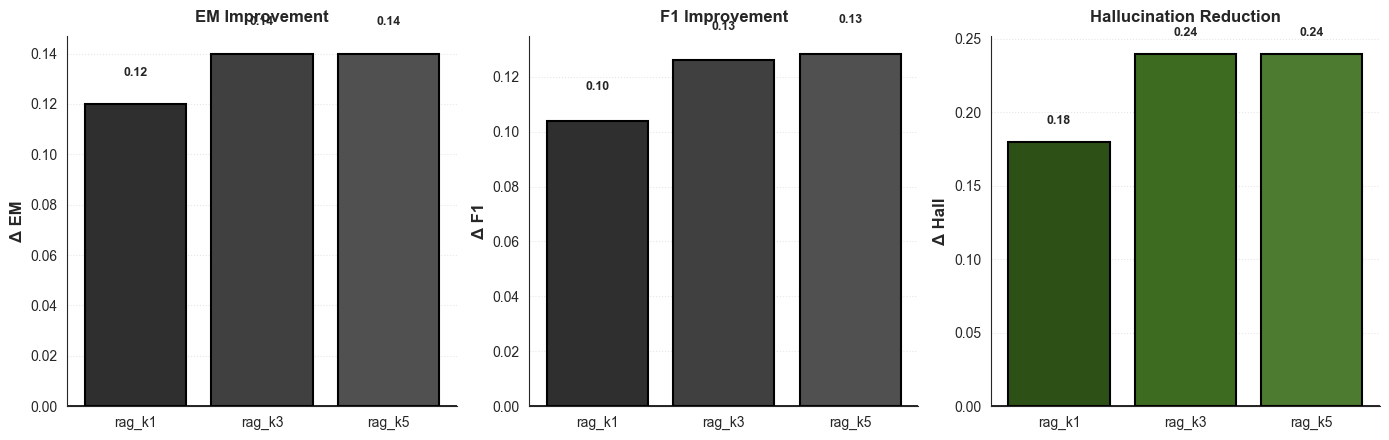

✓ Plot 5: Effect Sizes (grayscale + green for positive hallucination reduction)


In [28]:
# PLOT 5: Statistical Comparisons (Effect Sizes) - Grayscale with green for positive effects
fig, axes = plt.subplots(1, 3, figsize=(14, 4.5))

metrics = ['ΔEM', 'ΔF1', 'ΔHall']
titles = ['EM Improvement', 'F1 Improvement', 'Hallucination Reduction']
# Use grayscale, but green for hallucination reduction (positive outcome)
colors_list = [['#2F2F2F', '#404040', '#505050'],  # EM - grayscale
               ['#2F2F2F', '#404040', '#505050'],  # F1 - grayscale
               ['#2D5016', '#3D6B1F', '#4D7B2F']]  # Hallucination - dark green (positive outcome)

for i, (metric, title, colors) in enumerate(zip(metrics, titles, colors_list)):
    bars = axes[i].bar(range(len(comparison_df)), comparison_df[metric], 
                       color=colors, edgecolor='black', linewidth=1.5)
    axes[i].axhline(y=0, color='black', linestyle='-', linewidth=1.2)
    axes[i].set_xticks(range(len(comparison_df)))
    axes[i].set_xticklabels([c.split('vs ')[1] for c in comparison_df['Comparison']], 
                           rotation=0, fontsize=10)
    axes[i].set_ylabel(f'Δ {metric[1:]}', fontsize=12, fontweight='bold')
    axes[i].set_title(title, fontsize=12, fontweight='bold', pad=10)
    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)
    axes[i].tick_params(axis='both', which='major', labelsize=10)
    axes[i].grid(axis='y', alpha=0.2, linestyle=':', color='gray')
    
    # Add value labels (no significance stars since p=1.0)
    for j, val in enumerate(comparison_df[metric]):
        axes[i].text(j, val + (0.01 if val > 0 else -0.01), f'{val:.2f}', 
                    ha='center', va='bottom' if val > 0 else 'top', 
                    fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig('../presentation_plots/5_effect_sizes.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.savefig('../presentation_plots/5_effect_sizes.pdf', bbox_inches='tight', facecolor='white')
plt.show()
print("✓ Plot 5: Effect Sizes (grayscale + green for positive hallucination reduction)")

In [29]:
print("\n" + "="*60)
print("PRESENTATION PLOTS CREATED SUCCESSFULLY")
print("="*60)
print("\nAll 5 recommended plots saved to: presentation_plots/")
print("\nPlots created:")
print("  1. Hallucination Rate (red accent for emphasis)")
print("  2. Performance vs K (B&W with distinct line styles)")
print("  3. Accuracy Metrics (grayscale bars)")
print("  4. Correlation Analysis (grayscale scatter)")
print("  5. Effect Sizes (grayscale + green for positive outcomes)")
print("\nFormats: PNG (300 DPI) + PDF (vector)")
print("="*60)


PRESENTATION PLOTS CREATED SUCCESSFULLY

All 5 recommended plots saved to: presentation_plots/

Plots created:
  1. Hallucination Rate (red accent for emphasis)
  2. Performance vs K (B&W with distinct line styles)
  3. Accuracy Metrics (grayscale bars)
  4. Correlation Analysis (grayscale scatter)
  5. Effect Sizes (grayscale + green for positive outcomes)

Formats: PNG (300 DPI) + PDF (vector)
